In [1]:
# modules needed 
from csv import reader
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pdb
import netCDF4
import pandas as pd
import json
from cftime import date2num
import matplotlib.dates as dates

In [2]:
#import gsw

In [3]:
# LRAUV NetCDF variable names
# do we need to create a new NetCDF file for this?
# PAR umol/s/m^2
# bbp470. count
# bbp650. count
# bin_mean_mass_concentration_of_chlorophyll_in_sea_water. ug/l
# bin_mean_sea_water_salinity. psu
# bin_mean_sea_water_temperature. deg C
# chl. count (probably don't want)
# chlorophyll. ug/L
# depth
# salinity. psu
# temperature, deg C
# time, seconds since 2024-04-15T20:55:08
# particulatebackscattercoef470nm, 1/m
# particulatebackscattercoef650nm, 1/m
# fix_latitude, arcdeg
# fix_longitude, arcdge
# latitude, deg
# longitude, deg
# volumescatcoef117deg470nm, 1/m/sr
# volumescatcoef117deg650nm, 1/m/sr
# mass_concentration_of_oxygen_in_sea_water, ug/l, so this is 1000 times what normal units

In [4]:
#str1='202404152055_202404161703'
#str2='202404152055'
#str1='202404161703_202404171510'
#str2='202404161703'
#str1='202404171511_202404181621'
#str2='202404171511'
str1='202404181737_202404191741'
str2='202404181737'
#str1='202404191741_202404192129'
#str2='202404191741'

In [5]:
# data set to load
#file='nc_202404152055_202404161703_2S_scieng.nc.nc4'
#file='nc_202404161703_202404171510_2S_scieng.nc.nc4'
#file='nc_202404171511_202404181621_2S_scieng.nc.nc4'
#file='nc_202404181737_202404191741_2S_scieng.nc.nc4'
#file='nc_202404191741_202404192129_2S_scieng.nc.nc4'
file='nc_'+str1+'_2S_scieng.nc.nc4'
dataset=xr.open_dataset(file)
#file='x:/ayeris/binned_particles_vehicle_data_1666749676.csv'
#fobj=open(file,'r')

In [6]:
# open the file and get the variables we need
ahi=xr.open_dataset(file)
time=ahi['time']
lat=ahi['latitude']
lon=ahi['longitude']
dep=ahi['depth']
par=ahi['PAR']
chl=ahi['chlorophyll']
bc470=ahi['particulatebackscatteringcoeff470nm']
bc650=ahi['particulatebackscatteringcoeff650nm']
salt=ahi['salinity']
temp=ahi['temperature']
# do we need these? Using the above values for now
bchl=ahi['bin_mean_mass_concentration_of_chlorophyll_in_sea_water']
btemp=ahi['bin_mean_sea_water_temperature']
bsalt=ahi['bin_mean_sea_water_salinity']
ctemp=ahi['bin_median_sea_water_temperature']
csalt=ahi['bin_median_sea_water_salinity']

In [7]:
# set up glider DAC specific variables
profile_lat=[]
profile_lon=[]
profile_time=[]

In [8]:
# set up code to try and find where profiles start and end
# Since we don't have any indication of the start and stop we will have to infer it from the change in depth values.
dd=np.diff(dep)

In [9]:
# This uses the rate of change in depth to estimate when we change direction on a profile.
# once we change we keep the sign until we hit the next profile, It looks like it works okay.
flag='up'
tindex=[]
for jj in np.arange(0,len(dd)):
    if (dd[jj] > 0.2) and (flag=='up'):
        flag='down'
        tindex=np.append(tindex,int(jj))
    if (dd[jj] < -0.2) and (flag=='down'):
        flag='up'
        tindex=np.append(tindex,int(jj))

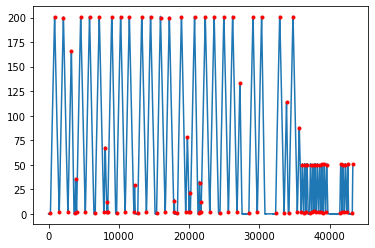

In [10]:
plt.plot(dep)
plt.plot(tindex,dep[tindex.astype(int)],'r.')


In [ ]:
# Okay now that we have the index of the profiles we can attemp to compute mean values for lat, lon, and time
nprofile=np.arange(0,len(tindex)-1)
profilenum=np.zeros(len(temp))
for k in nprofile:
    if k==0:
        # get data from the profile
        profilenum[0:int(tindex[k])]=k
        lattmp=lat[0:int(tindex[k])]
        lontmp=lon[0:int(tindex[k])]
        timetmp=pd.DataFrame(time[0:int(tindex[k])])
        # now compute the mean values and assign them to the profiles
        profile_lat=np.append(profile_lat,np.mean(lattmp))
        profile_lon=np.append(profile_lon,np.mean(lontmp))
        profile_time=np.append(profile_time,pd.Timestamp(np.mean([tsp.value for tsp in timetmp[0]])))
    else:
        profilenum[int(tindex[k]):int(tindex[k+1])]=k
        lattmp=lat[int(tindex[k]):int(tindex[k+1])]
        lontmp=lon[int(tindex[k]):int(tindex[k+1])]
        timetmp=pd.DataFrame(time[int(tindex[k]):int(tindex[k+1])])
        profile_lat=np.append(profile_lat,np.mean(lattmp))
        profile_lon=np.append(profile_lon,np.mean(lontmp))
        profile_time=np.append(profile_time,pd.Timestamp(np.mean([tsp.value for tsp in timetmp[0]])))
profilenum[int(tindex[k+1]):]=k+1
lattmp=lat[int(tindex[k+1]):-1]
lontmp=lon[int(tindex[k+1]):-1]
timetmp=pd.DataFrame(time[int(tindex[k+1]):-1])
profile_lat=np.append(profile_lat,np.mean(lattmp))
profile_lon=np.append(profile_lon,np.mean(lontmp))
profile_time=np.append(profile_time,pd.Timestamp(np.mean([tsp.value for tsp in timetmp[0]])))

In [ ]:
# set up some glider DAC specific variables
profile_lat=[]
profile_lon=[]
profile_time=[]

In [ ]:
# set up code to try and find where profiles start and end
# Since we don't have any indication of the start and stop we will have to infer it from the change in depth values.
dd=np.diff(dep)

In [ ]:
# This uses the rate of change in depth to estimate when we change direction on a profile.
# once we change we keep the sign until we hit the next profile, It looks like it works okay.
flag='up'
tindex=[]
for jj in np.arange(0,len(dd)):
    if (dd[jj] > 0.2) and (flag=='up'):
        flag='down'
        tindex=np.append(tindex,int(jj))
    if (dd[jj] < -0.2) and (flag=='down'):
        flag='up'
        tindex=np.append(tindex,int(jj))

In [ ]:
# Okay now that we have the index of the profiles we can attemp to compute mean values for lat, lon, and time
nprofile=np.arange(0,len(tindex)-1)
profilenum=np.zeros(len(temp))
for k in nprofile:
    if k==0:
        # get data from the profile
        profilenum[0:int(tindex[k])]=k
        lattmp=lat[0:int(tindex[k])]
        lontmp=lon[0:int(tindex[k])]
        timetmp=pd.DataFrame(time[0:int(tindex[k])])
        # now compute the mean values and assign them to the profiles
        profile_lat=np.append(profile_lat,np.mean(lattmp))
        profile_lon=np.append(profile_lon,np.mean(lontmp))
        profile_time=np.append(profile_time,pd.Timestamp(np.mean([tsp.value for tsp in timetmp[0]])))
    else:
        profilenum[int(tindex[k]):int(tindex[k+1])]=k
        lattmp=lat[int(tindex[k]):int(tindex[k+1])]
        lontmp=lon[int(tindex[k]):int(tindex[k+1])]
        timetmp=pd.DataFrame(time[int(tindex[k]):int(tindex[k+1])])
        profile_lat=np.append(profile_lat,np.mean(lattmp))
        profile_lon=np.append(profile_lon,np.mean(lontmp))
        profile_time=np.append(profile_time,pd.Timestamp(np.mean([tsp.value for tsp in timetmp[0]])))
profilenum[int(tindex[k+1]):]=k+1
lattmp=lat[int(tindex[k+1]):-1]
lontmp=lon[int(tindex[k+1]):-1]
timetmp=pd.DataFrame(time[int(tindex[k+1]):-1])
profile_lat=np.append(profile_lat,np.mean(lattmp))
profile_lon=np.append(profile_lon,np.mean(lontmp))
profile_time=np.append(profile_time,pd.Timestamp(np.mean([tsp.value for tsp in timetmp[0]])))

In [ ]:
# create NetCDF file of the output from the LRAUV
ncfile=netCDF4.Dataset('./lrauv_reformat/Ahi_'+str2+'.nc','w',format='NETCDF3_CLASSIC')
ncfile.createDimension('time',None)
ncfile.createDimension('profile',len(tindex))
atime=ncfile.createVariable('time','f8',('time',),fill_value=-999.0)
alat=ncfile.createVariable('latitude','f4',('time',),fill_value=-999.0)
alon=ncfile.createVariable('longitude','f4',('time',),fill_value=-999.0)

In [ ]:
# create global attributes
ncfile.Conventions='CF-1.6, ACDD-1.3'
ncfile.Metadata_Conventions='CF-1.6,Unidata Dataset Discovery v1.0'
ncfile.acknowlegment='Project is funded thanks to Gordon and Betty Moore Grant GBMF7583 and funding from the Packard Foundation'
ncfile.comment='Data from the Planktivore project LRAUV Ahi'
ncfile.cdm_data_type='Trajectory'
ncfile.contributor_name='Henry Ruhl, Thom Maughan, Paul Roberts'
#ncfile.contributor_name=data['contributor_name']
ncfile.contributor_role='PI, PI, PI'
#ncfile.contributor_role=data['contributor_role']
ncfile.creator_email='mccann@mbari.org'
#ncfile.creator_email=data['creator_email']
ncfile.creator_role='Creator of dataset'
#ncfile.creator_role=data['creator_role']
ncfile.creator_url=' '
#ncfile.creator_url=data['creator_url']
today=dt.datetime.today()
ncfile.date_created=today.strftime("%d/%m/%y")
ncfile.date_issued=today.strftime("%d/%m/%y")
ncfile.date_modified=today.strftime("%d/%m/%y")
ncfile.featureType='trajectory'
ncfile.format_version='IOOS_Glider_NetCDF_v2.0.nc'
ncfile.ncei_template_version='NCEI_NetCDF_Trajectory_Template_v2.0'
ncfile.geospatial_lat_max=np.max(lat)
ncfile.geospatial_lat_min=np.min(lat)
ncfile.geospatial_lat_resolution='seconds'
ncfile.geospatial_lat_units='degrees_north'
ncfile.geospatial_lon_max=np.max(lon)
ncfile.geospatial_lon_min=np.min(lon)
ncfile.geospatial_lon_resolution='seconds'
ncfile.geospatial_lon_units='degrees_east'
ncfile.geospatial_vertical_max=np.max(dep)
#ncfile.geospatial_vertical_max=np.max(depthbin)
ncfile.geospatial_vertical_min='0'
ncfile.geospatial_vertical_resolution='centimeter'
ncfile.geospatial_vertical_units='meter'
ncfile.geospatial_vertical_positive='down'
ncfile.history='NetCDF created 20240812'
#ncfile.history=data['history']
ncfile.id=str1
#ncfile.id='202404171511_202404181621'
#ncfile.id=data['id']
ncfile.gts_ingest='false'
ncfile.institution='Monterey Bay Aquarium Research Institute'
lrkeywords='AUVS > Autonomous Underwater Vehicles, Earth Science > Oceans > Ocean Pressure > Water Pressure, Earth Science > Oceans > Ocean Temperature > Water Temperature, Earth Science > Oceans > Salinity/Density > Conductivity, Earth Science > Oceans > Salinity/Density > Density, Earth Science > Oceans > Salinity/Density > Salinity'
ncfile.keywords=lrkeywords
#ncfile.keywords=data['keywords']
ncfile.keywords_vocabulary='GCMD Science Keywords'
#ncfile.keywords_vocabulary=data['keywords_vocabulary']
lrlice= 'This data may be redistributed and used without restriction.  Data provided as is with no expressed or implied assurance of quality assurance or quality control '
ncfile.license=lrlice
#ncfile.license=data['license']
ncfile.metadata_link=' '
#ncfile.metadata_link=data['metadata_link']
ncfile.naming_authority='org.mbari'
#ncfile.naming_authority=data['naming_authority']
ncfile.platform_type='MBARI LRAUV'
#ncfile.platform_type=data['platform_type']
ncfile.processing_level='level 2'
#ncfile.processing_level=data['processing_level']
ncfile.project='Planktivore'
#ncfile.project=data['project']
ncfile.publisher_email='flbahr@mbari.org'
#ncfile.publisher_email=data['publisher_email']
ncfile.publisher_name='Fred Bahr'
#ncfile.publisher_name=data['publisher_name']
ncfile.publisher_url='mbari.org'
#ncfile.publisher_url=data['publisher_url']
ncfile.references=' '
#ncfile.references=data['references']
ncfile.sea_name='Pacific Ocean'
ncfile.source='Planktivore'
#ncfile.source=data['source']
ncfile.summary='Planktivore CTD data from the LRAUV Ahi'
#ncfile.summary=data['summary']
ncfile.title='LRAUV Ahi CTD data from Synchro cruise'
#ncfile.title=data['title']
ncfile.wmo_id='N/A'
ncfile.ioos_regional_association='CeNCOOS'
ncfile.time_coverage_end=pd.Timestamp(time[-1].values).strftime("%d/%m/%y")
ncfile.time_coverage_start=pd.Timestamp(time[0].values).strftime("%d/%m/%y")
ncfile.time_coverage_resolution='seconds'

In [ ]:
thetime=pd.to_datetime(time)
offset=dt.datetime(1990,1,1)
xx=dates.date2num(thetime)-dates.date2num(offset)
myprofiletime=pd.to_datetime(profile_time)
xy=dates.date2num(myprofiletime)-dates.date2num(offset)

Open the NetCDF file and create variables, there is only one dimension variable for this file and that is time

In [ ]:
atime.axis='T'
atime.ancillary_variables='time_qc'
atime.calendar='gregorian'
atime.standard_name='time'
atime.long_name='time'
atime.units='days since 1990-01-01T00:00:00Z'
atime.observation_type='measured'
atime[:]=xx

In [ ]:
atraj=ncfile.createVariable('trajectory','c')
atraj.cf_role='trajectory_id'
atraj.comment='A trajectory is a single deployment of a glider and may span multiple data files'
atraj.long_name='Trajectory/Deployment/Name'
atraj=str1
#atraj='202404171511_202404181621'

In [ ]:
aprof=ncfile.createVariable('profile_id','i',('time',),fill_value=-999)
aprof.comment='Sequential profile number within the trajectory. This value is unique in each file that is part of a single trajectory/deployment'
aprof.long_name='ProfileID'
aprof.valid_min=1
aprof.valid_max=214783647
aprof[:]=profilenum

In [ ]:
aptime=ncfile.createVariable('profile_time','f4',('profile',),fill_value=-999)
aptime.calendar='gregorian'
aptime.comment='Timestamp corresponding to the mid-point of the profile'
aptime.long_name='Profile Center Time'
aptime.observation_type='calculated'
aptime.platform='platform'
aptime.standard_name='time'
aptime.units='days since 1990-01-01T00:00:00Z'
aptime.ancillary_variables='profile_time_qc'
aptime[:]=xy

In [ ]:
aplat=ncfile.createVariable('profile_lon','f4',('profile',),fill_value=-999)
aplat.comment='Mean profile longitude'
aplat.long_name='Longitude'
aplat.observation_type='measured'
aplat.platform='platform'
aplat.standard_name='longitude'
aplat.units='degrees_east'
aplat.valid_min=-180.0
aplat.valid_max=180.0
aplat.reference='WGS84'
aplat.coordinate_reference_frame='urn:ogc:crs:EPSG::4326'
aplat.ancillary_variables='profile_lon_qc'
aplat[:]=profile_lon

In [ ]:
aplat_qc=ncfile.createVariable('profile_lon_qc','f4',('profile',),fill_value=-999)
aplat_qc.comment='Mean profile longitude quality_flag'
aplat_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
aplat_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
aplat_qc.ioos_category='Quality'
aplat_qc.long_name='Longitude Quality Flag'
aplat_qc.observation_type='measured'
aplat_qc.platform='platform'
aplat_qc.standard_name='longitude quality_flag'
aplat_qc.valid_min=0
aplat_qc.valid_max=9
aplat_qc[:]=0.*profile_lat

In [ ]:
aplat=ncfile.createVariable('profile_lat','f4',('profile',),fill_value=-999)
aplat.comment='Mean profile latitude'
aplat.long_name='Latitude'
aplat.observation_type='measured'
aplat.platform='platform'
aplat.standard_name='latitude'
aplat.units='degrees_north'
aplat.valid_min=-90.0
aplat.valid_max=90.0
aplat.reference='WGS84'
aplat.coordinate_reference_frame='urn:ogc:crs:EPSG::4326'
aplat.ancillary_variables='profile_lat_qc'
aplat[:]=profile_lat

In [ ]:
aplat_qc=ncfile.createVariable('profile_lat_qc','f4',('profile',),fill_value=-999)
aplat_qc.comment='Mean profile latitude quality_flag'
aplat_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
aplat_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
aplat_qc.ioos_category='Quality'
aplat_qc.long_name='Latitude Quality Flag'
aplat_qc.observation_type='measured'
aplat_qc.platform='platform'
aplat_qc.standard_name='latitude quality_flag'
aplat_qc.valid_min=0
aplat_qc.valid_max=9
aplat_qc[:]=0.*profile_lat

In [ ]:
aptime_qc=ncfile.createVariable('profile_time_qc','i',('time',),fill_value=-127)
#aptime_qc.actual_range
aptime_qc.coordinates='time'
aptime_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
aptime_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
aptime_qc.ioos_category='Quality'
aptime_qc.long_name='Time Quality Flag'
aptime_qc.standard_name='time status_flag'
aptime_qc.valid_min=0
aptime_qc.valid_max=9
aptime_qc[:]=0*lat

In [ ]:
#alat._FillValue=-999.0
alat.ancillary_variables='lat_qc'
alat.comment='Some values may be linearly interpolated'
alat.coordinate_reference_frame='urn:ogc:crs:EPSG::4326'
alat.standard_name='latitude'
alat.long_name='Latitude'
alat.units='degrees_north'
alat.valid_min=-90.0
alat.valid_max=90.0
alat.axis='Y'
alat.platform='platform'
alat.reference='WGS84'
alat.observation_type='measured'
alat[:]=lat

In [ ]:
alat_qc=ncfile.createVariable('lat_qc','i',('time',),fill_value=-127)
alat_qc.actual_range="0, 0"
alat_qc.coordinates='time'
alat_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
alat_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
alat_qc.ioos_category='Quality'
alat_qc.long_name='Latitude Quality Flag'
alat_qc.standard_name='latitude status_flag'
alat_qc.valid_min=0
alat_qc.valid_max=9
alat_qc[:]=0*lat

In [ ]:
#alon._FillValue=-999.0
alon.ancillary_variables='lon_qc'
alon.comment='Some values may be linearly interpolated'
alon.coordinate_reference_frame='urn:ogc:crs:EPSG::4326'
alon.standard_name='longitude'
alon.long_name='Longitude'
alon.units='degrees_east'
alon.valid_min=-180.0
alon.valid_max=180.0
alon.axis='X'
alon.platform='platform'
alon.reference='WGS84'
alon.observation_type='measured'
alon[:]=lon

In [ ]:
alon_qc=ncfile.createVariable('lon_qc','i',('time',),fill_value=-127)
#alon_qc.actual_range
alon_qc.coordinates='time'
alon_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
alon_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
alon_qc.ioos_category='Quality'
alon_qc.long_name='Longitude Quality Flag'
alon_qc.standard_name='longitude status_flag'
alon_qc.valid_min=0
alon_qc.valid_max=9
alon_qc[:]=0*lat

In [ ]:
adepth=ncfile.createVariable('depth','f4',('time',), fill_value=-999.)
adepth.standard_name='depth'
adepth.units='m'
adepth.axis='Z'
adepth.long_name='Depth'
adepth.positive='down'
adepth[:]=-dep

In [ ]:
atemp=ncfile.createVariable('temperature','f4',('time',),fill_value=-1e34)
atemp.long_name='Temperature'
atemp.standard_name='sea_water_temperature'
atemp.units='Celsius'
atemp.valid_min=0
atemp.valid_max=30.0
atemp.resolution=0.001
atemp.observation_type='measured'
atemp.platform='platform'
atemp.instrument='instrument_ctd'
atemp.sensor_name=' '
atemp.accuracy=0.002
atemp.precision=0.001
atemp.ancillary_variables='temperature_qc'
atemp.comment='no comment'
atemp[:]=temp

In [ ]:
atemp_qc=ncfile.createVariable('temperature_qc','i',('time',),fill_value=-127)
#atemp_qc.actual_range
atemp_qc.coordinates='time'
atemp_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
atemp_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
atemp_qc.ioos_category='Quality'
atemp_qc.long_name='Temperature Quality Flag'
atemp_qc.standard_name='sea_water_temperature status_flag'
atemp_qc.valid_min=0
atemp_qc.valid_max=9
atemp_qc[:]=0*lat

In [ ]:
asalt=ncfile.createVariable('salinity','f4',('time',),fill_value=-1e34)
asalt.long_name='Sea water Salinity in-situ PSS 1978 scale'
asalt.standard_name='sea_water_practical_salinity'
asalt.units='0.001'
asalt.missing_value=-1e34
asalt.valid_min=0
asalt.valid_max=38.0
asalt.resolution=0.001
asalt.observation_type='calculated'
asalt.platform='platform'
asalt.instrument='instrument_ctd'
asalt.sensor_name=' '
asalt.accuracy=0.002
asalt.precision=0.001
asalt.ancillary_variables='salinity_qc'
asalt.comment='Salinity is based upon the Practical Salinity Scale of 1978 (PSS1978 and is without dimensions. The CF-1.4 convention recognizes that PSS78 is dimensionless yet recommends a unit of 0.001 to reflect parts per thousand'
asalt[:]=salt

In [ ]:
asalt_qc=ncfile.createVariable('salinity_qc','i',('time',),fill_value=-127)
#asalt_qc.actual_range
asalt_qc.coordinates='time'
asalt_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
asalt_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
asalt_qc.ioos_category='Quality'
asalt_qc.long_name='Salinity Quality Flag'
asalt_qc.standard_name='sea_water_practical_salinity status_flag'
asalt_qc.valid_min=0
asalt_qc.valid_max=9
asalt_qc[:]=0*lat

In [ ]:
achla=ncfile.createVariable('chlorophyll_a','f4',('time',),fill_value=-1e34)
achla.long_name='Chlorophyll a'
achla.standard_name='mass_concentration_of_chlorophyll_a_in_sea_water'
achla.units='micrograms/L' # NEED TO FIND OUT THE UNITS
achla.missing_value=-1e34
achla.valid_min=0
achla.valid_max=19.0
achla.resolution=0.001
achla.observation_type='measured'
achla.platform='platform'
achla.instrument='instrument_ctd'
achla.sensor_name=' '
achla.accuracy=0.002
achla.precision=0.001
achla.ancillary_variables='chlorophyll_qc'
achla[:]=chl

In [ ]:
achla_qc=ncfile.createVariable('chlorophyll_qc','i',('time',),fill_value=-127)
#achla_qc.actual_range
achla_qc.coordinates='time'
achla_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
achla_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
achla_qc.ioos_category='Quality'
achla_qc.long_name='Chlorophyll a Quality Flag'
achla_qc.standard_name='mass_concentration_of_chlorophyll_a_in_sea_water status_flag'
achla_qc.valid_min=0
achla_qc.valid_max=9
achla_qc[:]=0*lat

In [ ]:
a470=ncfile.createVariable('backscatter_coeffient_470nm','f4',('time',),fill_value=-1e34)
a470.long_name='backscatter coefficient 470nm'
a470.standard_name='backscatter_coefficient_470nm'
a470.units='1/m' # NEED TO FIND OUT THE UNITS
a470.missing_value=-1e34
a470.valid_min=0
a470.valid_max=19.0
a470.resolution=0.001
a470.observation_type='measured'
a470.platform='platform'
a470.instrument='instrument_ctd'
a470.sensor_name=' '
a470.accuracy=0.002
a470.precision=0.001
a470.ancillary_variables='backscatter_coefficient_470nm_qc'
a470[:]=bc470

In [ ]:
a470_qc=ncfile.createVariable('backscatter_coefficient_470nm_qc','i',('time',),fill_value=-127)
#achla_qc.actual_range
a470_qc.coordinates='time'
a470_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
a470_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
a470_qc.ioos_category='Quality'
a470_qc.long_name='470nm backscatter Coefficient Quality Flag'
a470_qc.standard_name='backscatter_coefficient_470nm status_flag'
a470_qc.valid_min=0
a470_qc.valid_max=9
a470_qc[:]=0*lat

In [ ]:
a650=ncfile.createVariable('backscatter_coeffient_650nm','f4',('time',),fill_value=-1e34)
a650.long_name='backscatter coefficient 650nm'
a650.standard_name='backscatter_coefficient_650nm'
a650.units='1/m' # NEED TO FIND OUT THE UNITS
a650.missing_value=-1e34
a650.valid_min=0
a650.valid_max=19.0
a650.resolution=0.001
a650.observation_type='measured'
a650.platform='platform'
a650.instrument='instrument_ctd'
a650.sensor_name=' '
a650.accuracy=0.002
a650.precision=0.001
a650.ancillary_variables='backscatter_coefficient_650nm_qc'
a650[:]=bc650

In [ ]:
a650_qc=ncfile.createVariable('backscatter_coefficient_650nm_qc','i',('time',),fill_value=-127)
#achla_qc.actual_range
a650_qc.coordinates='time'
a650_qc.flag_meanings='no_qc_preformed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed interpolated_value missing_value'
a650_qc.flag_values='0,1,2,3,4,5,6,7,8,9'
a650_qc.ioos_category='Quality'
a650_qc.long_name='650nm Backscattering coefficient Quality Flag'
a650_qc.standard_name='backscatter_coefficient_650nm status_flag'
a650_qc.valid_min=0
a650_qc.valid_max=9
a650_qc[:]=0*lat

In [ ]:
ncfile.close()